In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## About this Dataset

This data has been collected from two solar power plants over a 34-day period. It represents both power generation and weather data from two distinct plants. The power generation datasets are collected at the inverter level, with each inverter connected to multiple lines of solar panels. Weather data is gathered using sensors positioned at the plant level, utilizing a single array of sensors strategically placed within each plant.


#### Power generation dataset :
- **DATE_TIME**: Timestamp representing the date and time of the recorded data point.
- **PLANT_ID**: A unique identifier for the solar power plant from which the data was collected.
- **SOURCE_KEY**: A unique identifier for each inverter (Inverters are responsible for converting DC power into AC power).
- **DC_POWER**: The direct current (DC) power generated by the solar panels.
- **AC_POWER**: The alternating current (AC) power generated by the solar panels after conversion.
- **DAILY_YIELD**: The cumulative daily energy yield from the solar panels, often measured in (kWh).
- **TOTAL_YIELD**: The cumulative total energy yield from the solar panels over the entire period of data collection.

#### Weather dataset :
- **DATE_TIME**: A timestamp, as in the power data, representing the date and time of the recorded weather data.
- **PLANT_ID**: The same unique identifier for the solar power plant as in the power data.
- **SOURCE_KEY**: a single inverter is used in the weather measurment, thus a unique value.
- **AMBIENT_TEMPERATURE**: The ambient temperature (°C) at the solar power plant location.
- **MODULE_TEMPERATURE**: The temperature (°C) of the solar panel modules.
- **IRRADIATION**: The level of solar irradiation, or solar energy received at the location, often measured in W/m².


## Study Goal

The objective this research is to predict the energy output that solar modules will generate on the following day based on the power generation data and weather measurements from the preceding day.

**NOTE**: After a preliminary examination of both plant datasets, it is evident that the second plant's data exhibits a significant number of missing values, with up to 30% of the power generation data being incomplete. As a result, I have chosen to focus exclusively on the data from plant 1 for this study, which has a more manageable 5% rate of missing values.

## Load and Clean data

In [2]:
power_data = pd.read_csv("./Dataset/Plant_1_Generation_Data.csv")
weather_data = pd.read_csv("./Dataset/Plant_1_Weather_Sensor_Data.csv")

### 1- Power generation data

In [3]:
power_data.shape

(68778, 7)

In [4]:
power_data.dtypes

DATE_TIME       object
PLANT_ID         int64
SOURCE_KEY      object
DC_POWER       float64
AC_POWER       float64
DAILY_YIELD    float64
TOTAL_YIELD    float64
dtype: object

In [5]:
# the feature "PLANT_ID" seems to have the same value 4136001 and thus should be safely dropped
print("feature 'PLANT_ID' count:", len(power_data["PLANT_ID"].unique()))
power_data = power_data.drop(["PLANT_ID"], axis=1)

feature 'PLANT_ID' count: 1


In [6]:
# there are 22 inverters in this plant
inverters = power_data["SOURCE_KEY"].unique()
print(f"Plant inverter count: {len(inverters)}")
print(f"Plant inverters:\n {inverters}")

Plant inverter count: 22
Plant inverters:
 ['1BY6WEcLGh8j5v7' '1IF53ai7Xc0U56Y' '3PZuoBAID5Wc2HD' '7JYdWkrLSPkdwr4'
 'McdE0feGgRqW7Ca' 'VHMLBKoKgIrUVDU' 'WRmjgnKYAwPKWDb' 'ZnxXDlPa8U1GXgE'
 'ZoEaEvLYb1n2sOq' 'adLQvlD726eNBSB' 'bvBOhCH3iADSZry' 'iCRJl6heRkivqQ3'
 'ih0vzX44oOqAx2f' 'pkci93gMrogZuBj' 'rGa61gmuvPhdLxV' 'sjndEbLyjtCKgGv'
 'uHbuxQJl8lW7ozc' 'wCURE6d3bPkepu2' 'z9Y9gH1T5YWrNuG' 'zBIq5rxdHJRwDNY'
 'zVJPv84UY57bAof' 'YxYtjZvoooNbGkE']


In [7]:
# change the inverters names for simplicity
power_data["INVERTER"] = power_data["SOURCE_KEY"].map({v: f'INV_{k}' for k, v in enumerate(inverters)})
power_data = power_data.drop(["SOURCE_KEY"], axis=1)

In [8]:
# verify missing data for each inverter data
expected_sample_per_inverter = 34*24*4 # (34days with a 15min sampling period)
(power_data["INVERTER"].value_counts() / expected_sample_per_inverter) * 100

INV_10    96.660539
INV_0     96.629902
INV_3     95.986520
INV_5     95.986520
INV_7     95.894608
INV_12    95.894608
INV_18    95.772059
INV_17    95.772059
INV_16    95.741422
INV_13    95.741422
INV_11    95.741422
INV_14    95.710784
INV_15    95.710784
INV_4     95.710784
INV_20    95.710784
INV_8     95.680147
INV_1     95.557598
INV_9     95.557598
INV_19    95.557598
INV_6     95.526961
INV_2     95.526961
INV_21    95.098039
Name: INVERTER, dtype: float64

It appears that all inverters have missing values, accounting for approximately 5% of the total data.

In [9]:
# Check if all datetimes are present using frequency
power_data["DATE_TIME"] = pd.to_datetime(power_data["DATE_TIME"], format='%d-%m-%Y %H:%M')
print(f"Data datetime frequency : {power_data['DATE_TIME'].array.freq}")

Data datetime frequency : None


The absence of a returned frequency (None) indicates the presence of missing datetimes. To identify these gaps, we can compare the datetimes in the original dataset with a 15-min date range created for the same time period.

In [10]:
# construct a 34 days with 15min intervals from data start-end dates
datetimes = power_data["DATE_TIME"]
datetime_fullrange = pd.date_range(start=min(datetimes), end=max(datetimes), freq='15min')
print(f"Missing datetimes: {len(datetime_fullrange.difference(datetimes.unique()))}")

Missing datetimes: 106


### Filling out missing datetimes

It's important to observe that the missing values identified above concerns to the entire dataset. Additionally, when we examined the missing values for individual inverters, we notice that some of them have a higher number of missing samples, indicating a greater number of missing dates.

To address these gaps and complete the missing datetimes for each inverter, we need to separately reindex the datetimes for each inverter and subsequently merge them back together.

In [11]:
fullrange = pd.Series(datetime_fullrange, name='DATE_TIME')

data = []
for inverter in power_data["INVERTER"].unique():
    df = power_data[power_data.INVERTER == inverter]
    df = df.merge(fullrange, on='DATE_TIME', how='right')
    df['INVERTER'] = inverter
    data.append(df)
power_df = pd.concat(data)

In [12]:
# Check new data for missing values
power_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71808 entries, 0 to 3263
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATE_TIME    71808 non-null  datetime64[ns]
 1   DC_POWER     68778 non-null  float64       
 2   AC_POWER     68778 non-null  float64       
 3   DAILY_YIELD  68778 non-null  float64       
 4   TOTAL_YIELD  68778 non-null  float64       
 5   INVERTER     71808 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 3.8+ MB


In [13]:
# check for null values
power_df.isna().sum()

DATE_TIME         0
DC_POWER       3030
AC_POWER       3030
DAILY_YIELD    3030
TOTAL_YIELD    3030
INVERTER          0
dtype: int64

It is expected that the data now contains NaN values, which were introduced when we added all the missing timestamps for each inverter. To use this data, we must first address these missing values using one of the common filling methods: the use of previous/next item or interpolation or using KNN imputer.

Since in our study we need also to considere the weather data which may also contain missing values, we will leave the imputing step for later when we'll have both datasets combined.

### 2- Weather data

In [14]:
weather_data.head()

DATE_TIME  PLANT_ID       SOURCE_KEY  AMBIENT_TEMPERATURE  \
0  2020-05-15 00:00:00   4135001  HmiyD2TTLFNqkNe            25.184316   
1  2020-05-15 00:15:00   4135001  HmiyD2TTLFNqkNe            25.084589   
2  2020-05-15 00:30:00   4135001  HmiyD2TTLFNqkNe            24.935753   
3  2020-05-15 00:45:00   4135001  HmiyD2TTLFNqkNe            24.846130   
4  2020-05-15 01:00:00   4135001  HmiyD2TTLFNqkNe            24.621525   

   MODULE_TEMPERATURE  IRRADIATION  
0           22.857507          0.0  
1           22.761668          0.0  
2           22.592306          0.0  
3           22.360852          0.0  
4           22.165423          0.0

In [15]:
print("feature 'PLANT_ID' count:", len(weather_data["PLANT_ID"].unique()))
print("feature 'SOURCE_KEY' count:", len(weather_data["SOURCE_KEY"].unique()))

feature 'PLANT_ID' count: 1
feature 'SOURCE_KEY' count: 1


Earlier, we mentioned that we can omit the 'PLANT_ID' feature since we're working with a single plant. Additionally, we can now exclude the inverter columns ('SOURCE_KEY' feature) from the data, this is because the weather data is collected at the location of one inverter, and we assume it to be consistent across all inverters, accurately representing the entire plant.

In [16]:
weather_data = weather_data.drop(["PLANT_ID", "SOURCE_KEY"], axis=1)

In [17]:
# check if there are missing values
weather_data.isna().sum()

DATE_TIME              0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64

In [18]:
# check if there are missing datetimes
weather_data["DATE_TIME"] = pd.to_datetime(weather_data["DATE_TIME"], format='%Y-%m-%d %H:%M:%S')
print(f"Data datetime frequency : {weather_data['DATE_TIME'].array.freq}")

Data datetime frequency : None


In [19]:
datetimes = weather_data["DATE_TIME"]
datetime_fullrange = pd.date_range(start=min(datetimes), end=max(datetimes), freq='15min')
print(f"Missing datetimes: {len(datetime_fullrange.difference(datetimes.unique()))}")

Missing datetimes: 82


### Filling out missing datetimes

No datetime frequency indicates that the weather data has also some missing timestamps, which we must add to be able to combine with the power generation data.

In [20]:
cols = weather_data.columns
weather_data = weather_data.set_index('DATE_TIME').reindex(datetime_fullrange).reset_index()
weather_data.columns = cols

In [21]:
weather_data.isna().sum()

DATE_TIME               0
AMBIENT_TEMPERATURE    82
MODULE_TEMPERATURE     82
IRRADIATION            82
dtype: int64

After adding the missing date-times, we see that there are null values introduced in the other features : 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE','IRRADIATION'. These gaps should be filled with the missing values we identified previously in the power generation dataset before proceeding to the modeling phase.

In [22]:
weather_data.head()

DATE_TIME  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION
0 2020-05-15 00:00:00            25.184316           22.857507          0.0
1 2020-05-15 00:15:00            25.084589           22.761668          0.0
2 2020-05-15 00:30:00            24.935753           22.592306          0.0
3 2020-05-15 00:45:00            24.846130           22.360852          0.0
4 2020-05-15 01:00:00            24.621525           22.165423          0.0

In [23]:
# augment weather data to account for multiple inverters
weather_df = pd.concat([weather_data for i in range(len(inverters))])

In [24]:
# combine the power generation and weather dataframes
data = pd.merge(power_df, weather_data, on="DATE_TIME")

In [25]:
data.head()

DATE_TIME  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD INVERTER  \
0 2020-05-15       0.0       0.0          0.0    6259559.0    INV_0   
1 2020-05-15       0.0       0.0          0.0    6183645.0    INV_1   
2 2020-05-15       0.0       0.0          0.0    6987759.0    INV_2   
3 2020-05-15       0.0       0.0          0.0    7602960.0    INV_3   
4 2020-05-15       0.0       0.0          0.0    7158964.0    INV_4   

   AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  
0            25.184316           22.857507          0.0  
1            25.184316           22.857507          0.0  
2            25.184316           22.857507          0.0  
3            25.184316           22.857507          0.0  
4            25.184316           22.857507          0.0

## Exploratory data analysis

In [26]:
# We extract more features from DATE_TIME
data['hour'] = data.DATE_TIME.dt.hour
data['dayofweek'] = data.DATE_TIME.dt.dayofweek

# Convert day of year to days of our study period (1-34)
days = data.DATE_TIME.dt.dayofyear
data['day'] = days.map({days.unique()[i-1]:i for i in range(1, 35)})

# Transform 15 min intervals into labels going from 1-96(24*4)
times = data.DATE_TIME.dt.time.unique()
data['interval'] = data.DATE_TIME.dt.time.map({times[i-1]: i for i in range(1, len(times)+1)})

In [27]:
# use data without missing values for the moment
df_na = data[~data.isna()]

### Data Correlation

<Axes: >

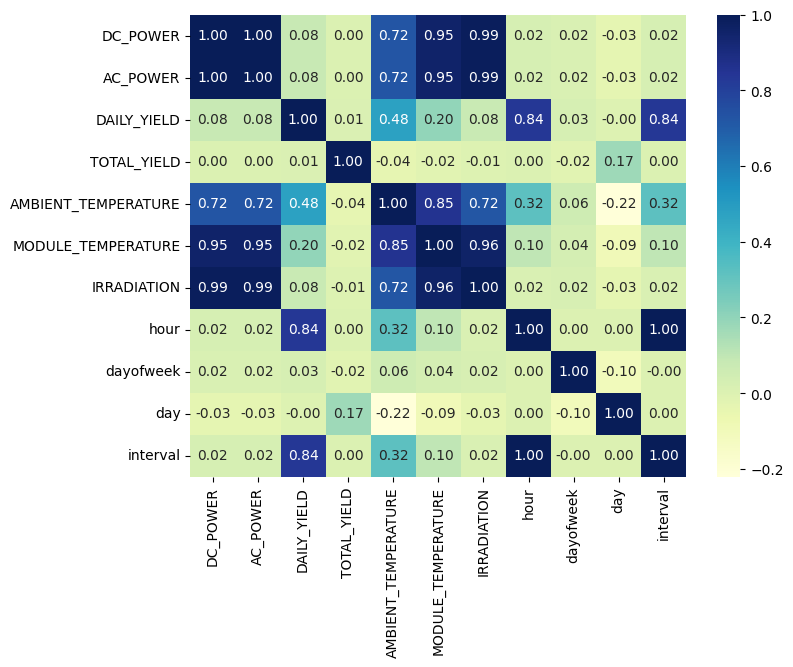

In [28]:
# Let's see the correlation between our features
plt.figure(figsize=(8, 6))
sns.heatmap(df_na.corr(numeric_only=True), cmap='YlGnBu', fmt='.2f', annot=True)

we can extract the following insights:

* High correlation exists between AC and DC power, which is expected because AC power is directly converted from DC power generated by the solar panels. Consequently, when designing the model to predict AC power, it's crucial to exclude DC power from the features to prevent data leakage.

* The more there is sunlight the more power will be generated by the solar panels which is highlighted in the strong relation between DC/AC power generated and irradiation.

* Solar panels are consistently exposed to ambient temperature, explaining the correlation with the module temperature. Although module temperature tends to be higher during power generation.

* The relationship between temperature and sun irradiation is self-evident, requiring no further explanation.

* A clear correlation emerges between daily yield and the time of day (or interval), this relationship is easily explained as the yield begins at zero during nighttime and gradually increases throughout the day due to sun irradiation, ultimately reaching a peak before returning to zero after sunset.

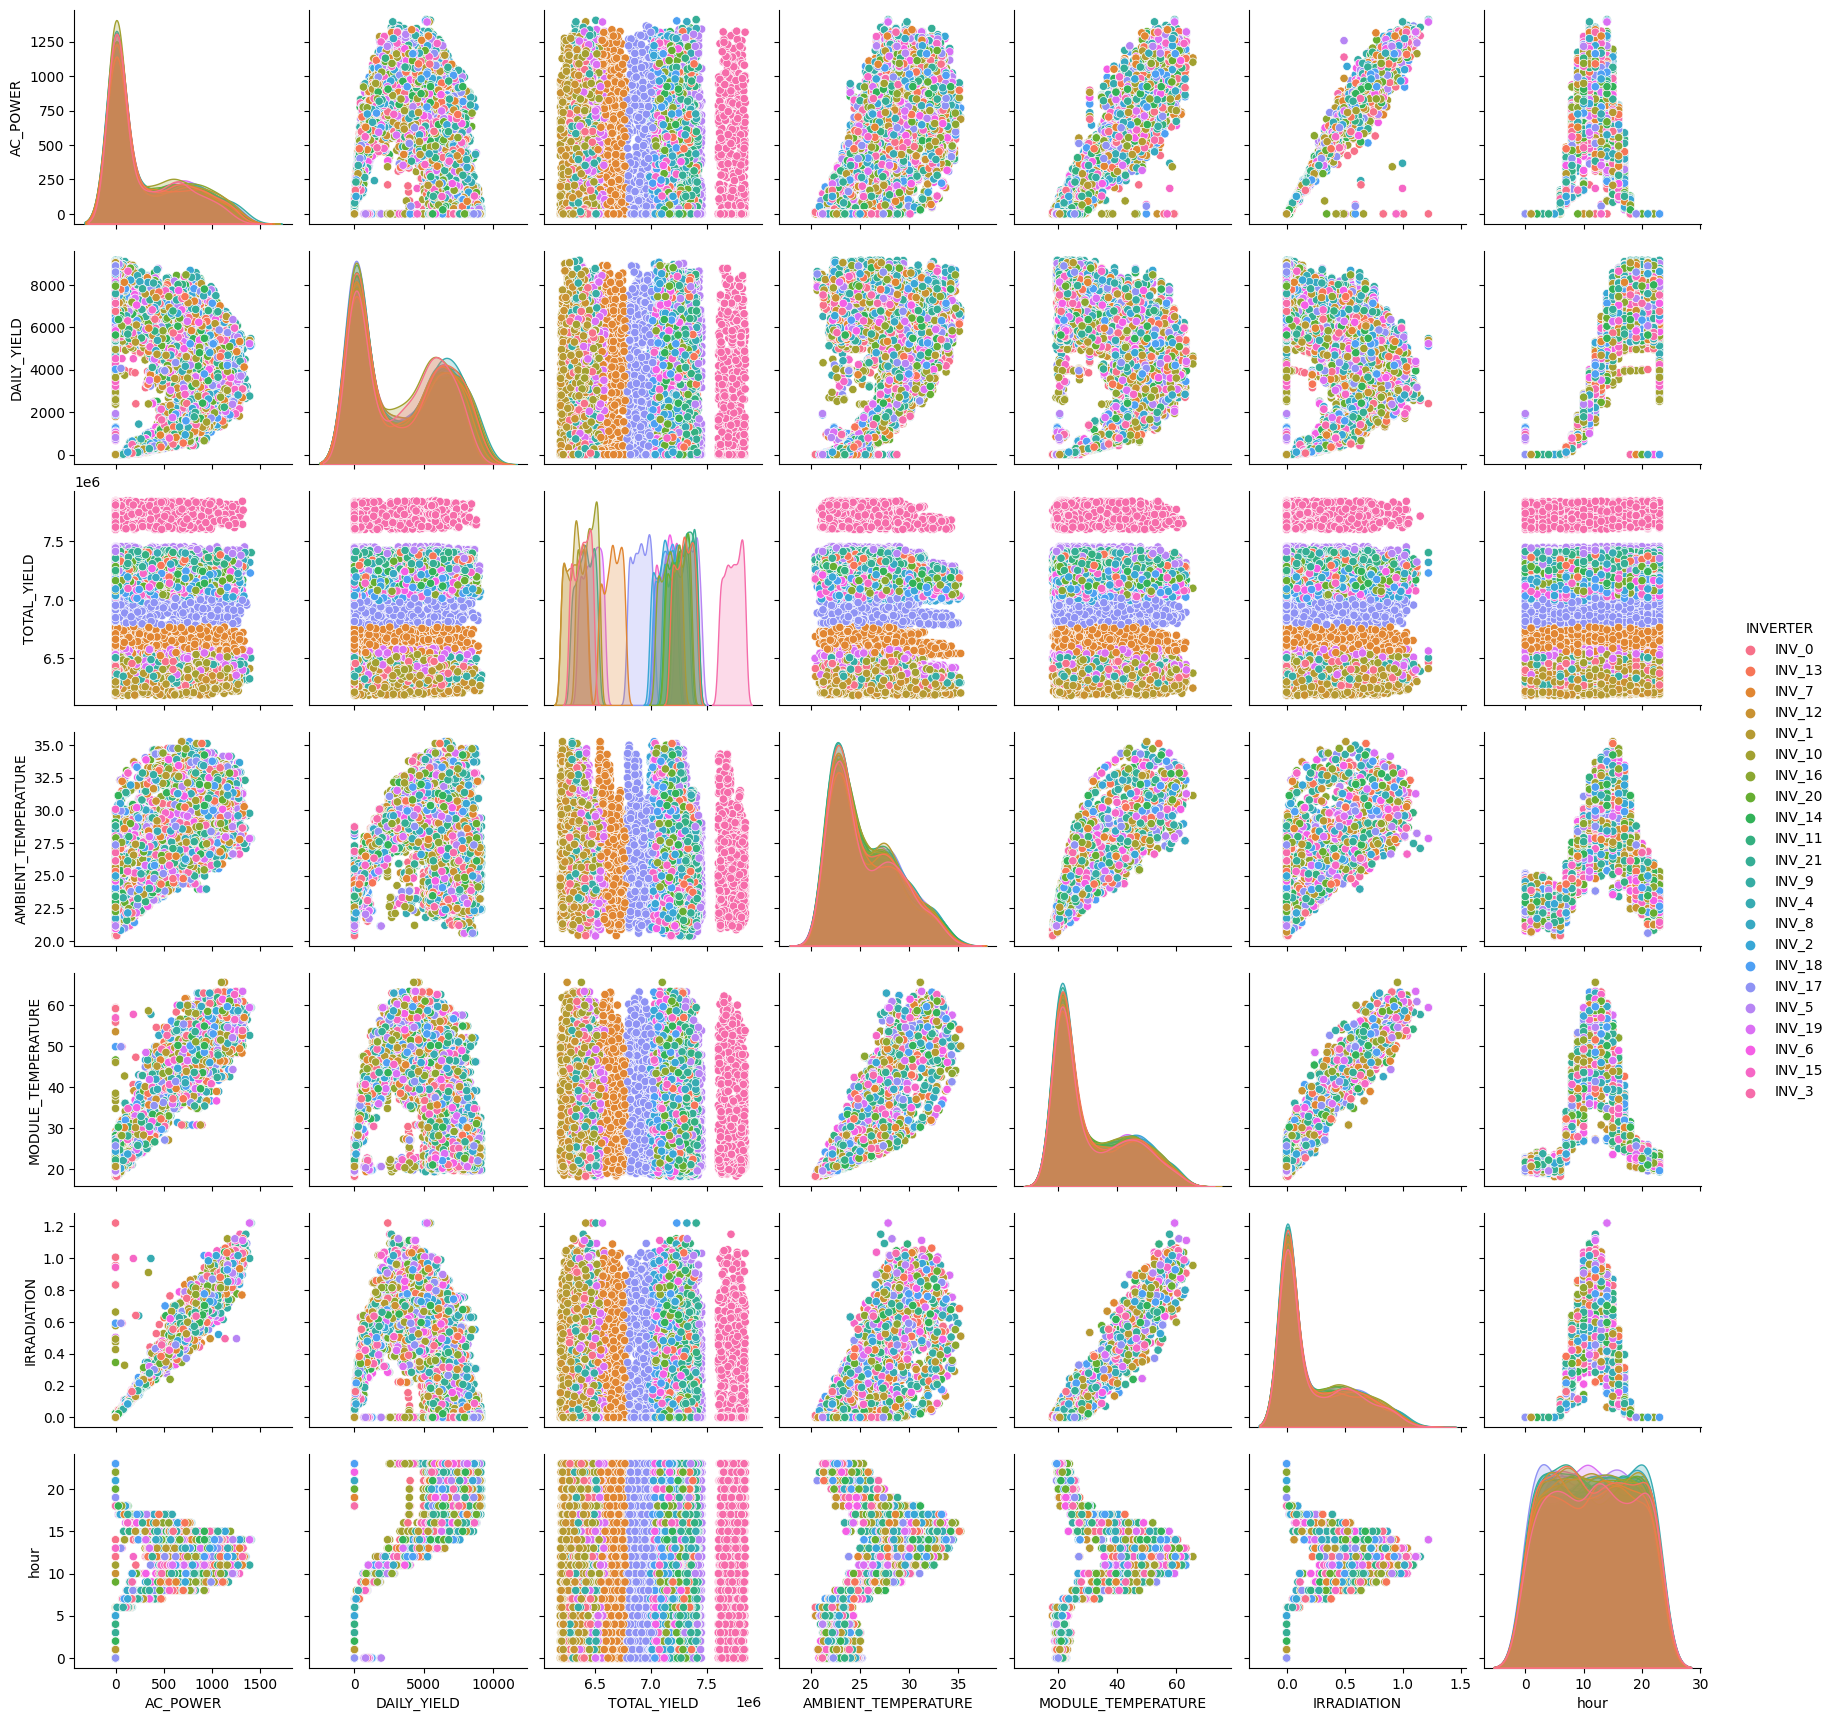

In [29]:
# plot features distribution considering previous correlation
data_dist = data[['AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD', 'AMBIENT_TEMPERATURE',
                  'MODULE_TEMPERATURE', 'IRRADIATION','hour', 'INVERTER']]
sns.pairplot(data_dist.sample(20000, random_state=0), hue='INVERTER')

* The observed distributions confirm the direct relationships between temperature and irradiation, as well as between AC power/Daily yield and irradiation.

* The evolution of AC power generated throughout the day hours exhibits a bell-shaped curve, with a peak typically occurring around midday, aligning with our expectations under normal conditions.

* AC power and daily yield distributions display a zero-skewness, primarily due to the presence of zero values (absence of sun irradiace) during nighttime when solar panels are inactive.

* There are outliers visible in the AC power and daily yield plots, which should be addressed before modeling stage.

### Removing outliers

Before addressing the numerous missing values within the final dataframe, it's imperative to tackle potential outliers. These outliers may signify either zero yield or power (AC/DC) during daylight hours, or inaccuracies in sensor measurements within the weather data.

In [30]:
def plot_outliers(data, feature):
    """
    Plots outliers for a given feature in the provided data using the percentile method.
    Outliers are detected based on the specified feature and are determined by values
    falling outside the 1% and 99% percentiles for each interval.

    Parameters:
    - data (DataFrame): The input DataFrame containing the data.
    - feature (str): The name of the feature for which outliers will be detected and plotted.
    """

    df = data.copy()
    df = df.merge(df.groupby('interval')
                .quantile(0.01, numeric_only=True)[feature]\
                .rename('OUTLIERS_LOW'),
                 on='interval',
                 how='left')
    df = df.merge(df.groupby('interval')\
                .quantile(0.99, numeric_only=True)[feature]\
                .rename('OUTLIERS_HIGH'),
                 on='interval',
                 how='left')
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.scatterplot(data=df, y=feature, x='interval', hue='INVERTER',
                    palette='gray', alpha=0.1, legend=False)
    sns.scatterplot(data=df.query(f'{feature} > OUTLIERS_HIGH'), y=feature, x='interval')
    sns.scatterplot(data=df.query(f'{feature} < OUTLIERS_LOW'), y=feature, x='interval')

    plt.ylabel(feature)
    plt.xlabel('Hour of Day')
    ax.set_xticks([i for i in range(1, 97, 4)])
    ax.set_xticklabels([i for i in range(24)])
    ax.legend(['data', 'outliers_high', 'outliers_low'])

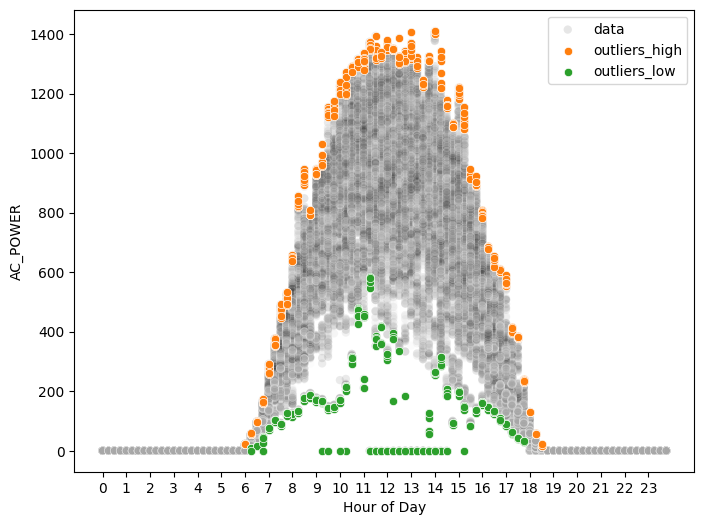

In [31]:
plot_outliers(df_na, "AC_POWER")

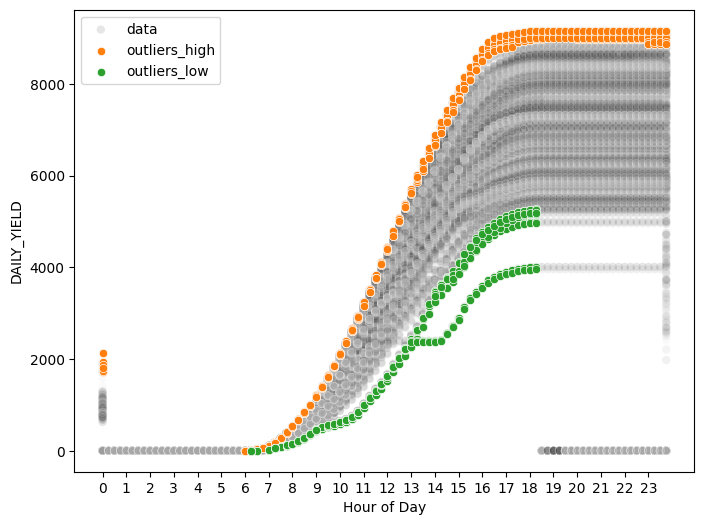

In [32]:
plot_outliers(df_na, "DAILY_YIELD")

* The plot indicates the presence of outliers in the features (considering the specified percentile threshold), these outliers include instances of null power generation values during daytime, which may be attributed to various factors such as measurement inaccuracies, shading, or inverter stopped for maintenance.

* Furthermore, strange values are observed in the daily yield plot, featuring anomalous occurrences, notably zeros occurring after 6:30pm and a column of data points at 0am. These anomalies appear to be incorrect measurements and should be eliminated.

* As for the remaining outlier values, we will treat them as missing data points and handle them during the process of imputing our global dataframe.

In [33]:
# Act directly on the overall data
# Remove zero values at 0am
data.DAILY_YIELD = data.DAILY_YIELD.mask(data.hour == 0, 0)

In [34]:
# night times from => 74 (6:30pm) -> 96 (00:00pm)
night_times = [i for i in range(74, 97)]

# fild max daily yield for each inverter at each interval
daily_max = pd.DataFrame({"DAILY_YIELD_MAX": data.groupby(["INVERTER", "day"]).max()["DAILY_YIELD"]}).reset_index()
data = data.merge(daily_max, on=["INVERTER", "day"], how="right")

# replace nighttime anomalies with max daily yield
data.DAILY_YIELD = data.DAILY_YIELD.mask(data.interval.isin(night_times), data.DAILY_YIELD_MAX)

# drop "DAILY_YIELD_MAX" columns as it's not needed
data = data.drop(["DAILY_YIELD_MAX"], axis=1)

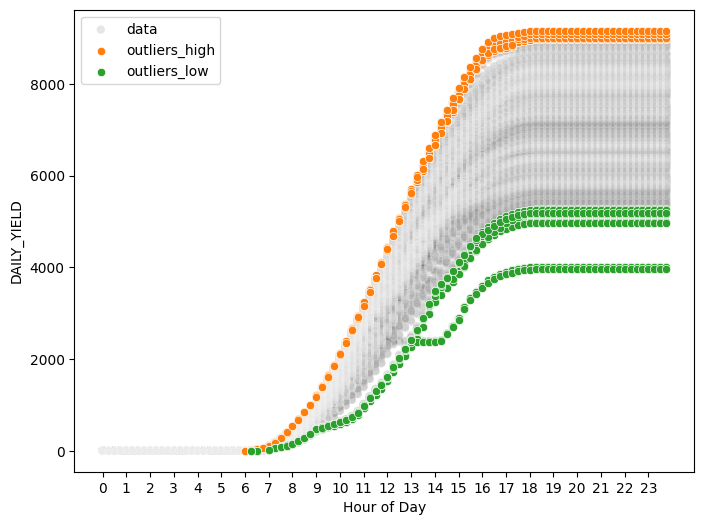

In [35]:
plot_outliers(data, "DAILY_YIELD")

In [36]:
def replace_outliers(data, feature):
    df = data.copy()
    df = df.merge(df.groupby('interval')
                .quantile(0.01, numeric_only=True)[feature]\
                .rename('OUTLIERS_LOW'),
                 on='interval',
                 how='left')
    df = df.merge(df.groupby('interval')\
                .quantile(0.99, numeric_only=True)[feature]\
                .rename('OUTLIERS_HIGH'),
                 on='interval',
                 how='left')
    outliers = (df[feature] < df.OUTLIERS_LOW) | (df[feature] > df.OUTLIERS_HIGH)
    data[feature] = df[feature].mask(outliers, np.NAN)

In [37]:
# replace most extreme outliers with Nan to handle them when imputing
replace_outliers(data, "AC_POWER")
replace_outliers(data, "DC_POWER")

In [38]:
data.isna().sum()

DATE_TIME                 0
DC_POWER               3806
AC_POWER               3807
DAILY_YIELD            1854
TOTAL_YIELD            3030
INVERTER                  0
AMBIENT_TEMPERATURE    1804
MODULE_TEMPERATURE     1804
IRRADIATION            1804
hour                      0
dayofweek                 0
day                       0
interval                  0
dtype: int64

### Imputing missing data

In order to address missing values, we can employ various approaches. In this context, we will considere here training a KNN imputer model and the use of the interpolation technique. After comparing the outcomes, we will select the method that yields the most favorable results.

In [39]:
# find the days with highest missing values count
data[data.AC_POWER.isna()].day.value_counts().head()

7     752
15    629
6     440
9     182
2     178
Name: day, dtype: int64

In [40]:
def plot_most_missing_data_days(data, feature):
    fig, axes = plt.subplots(1, 4, figsize=(12, 3), sharey=True)
    sns.scatterplot(data=data[(data.day == 7)], x='interval', y=feature,
                    hue='INVERTER', legend=False, ax=axes[0])
    axes[0].set_title("Day 7")
    sns.scatterplot(data=data[(data.day == 15)], x='interval', y=feature,
                    hue='INVERTER', legend=False, ax=axes[1])
    axes[1].set_title("Day 15")
    sns.scatterplot(data=data[(data.day == 6)], x='interval', y=feature,
                    hue='INVERTER', legend=False, ax=axes[2])
    axes[2].set_title("Day 6")
    sns.scatterplot(data=data[(data.day == 9)], x='interval', y=feature,
                    hue='INVERTER', legend=False, ax=axes[3])
    axes[3].set_title("Day 9")

    plt.tight_layout()
    plt.show()

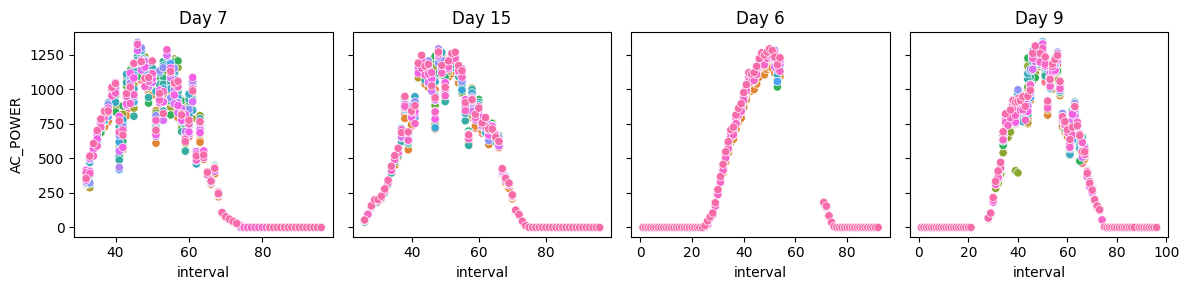

In [41]:
# Plot the AC power for the 4 days with most missing data
plot_most_missing_data_days(data, "AC_POWER")

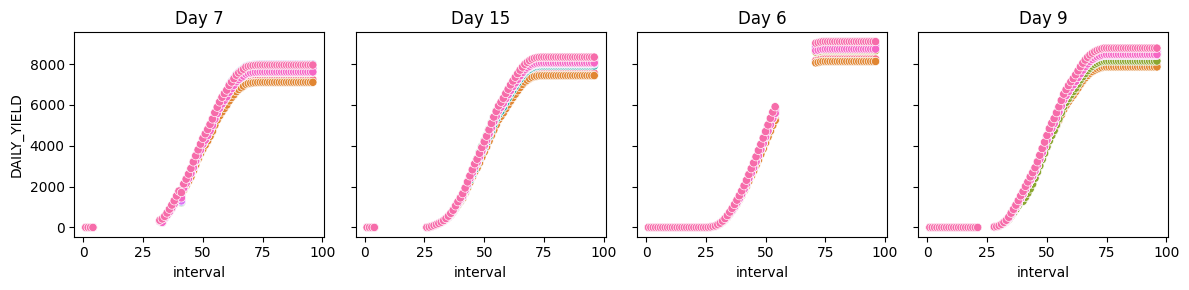

In [42]:
# Plot the Daily yield for the 4 days with most missing data
plot_most_missing_data_days(data, "DAILY_YIELD")

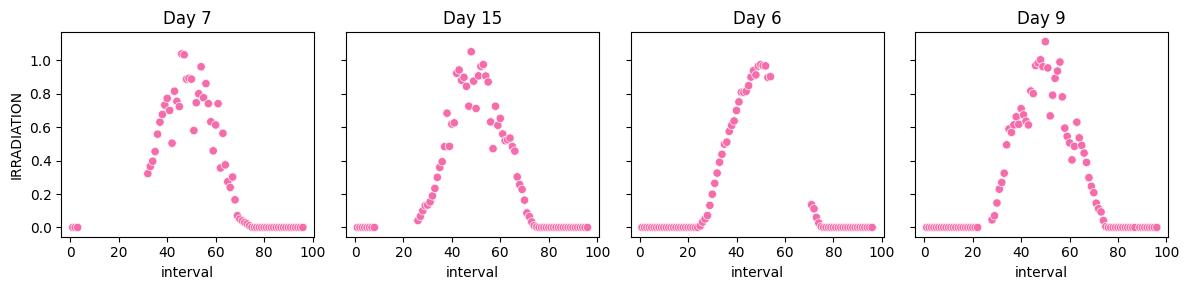

In [43]:
# Plot the IRRADIATION for the 4 days with most missing data
plot_most_missing_data_days(data, "IRRADIATION")

### 1- KNN imputer :

In [44]:
from sklearn.impute import KNNImputer

def impute_with_KNN(data):
    dfs = []
    df = data.copy()
    imputer = KNNImputer(n_neighbors=4)
    for i in df.INVERTER.unique():
        inverter_df = df[df.INVERTER == i]
        datetime = inverter_df.DATE_TIME
        inverter_df.index = datetime
        inverter_df = inverter_df.drop(["INVERTER", "DATE_TIME"], axis=1)
        inverter_df = pd.DataFrame(imputer.fit_transform(inverter_df),
                                   columns=inverter_df.columns,
                                   index=datetime)
        inverter_df["INVERTER"] = i
        inverter_df = inverter_df.reset_index()
        dfs.append(inverter_df)
    return pd.concat(dfs)

In [45]:
df_knn = impute_with_KNN(data)

### 2- Interpolation :

In [46]:
def impute_with_interpolation(data):
    dfs = []
    df = data.copy()
    imputer = KNNImputer(n_neighbors=5)
    for i in df.INVERTER.unique():
        inverter_df = df[df.INVERTER == i]
        datetime = inverter_df.DATE_TIME
        inverter_df.index = datetime
        inverter_df = inverter_df.drop(["INVERTER", "DATE_TIME"], axis=1)
        inverter_df = inverter_df.interpolate(method='linear')
        inverter_df["INVERTER"] = i
        inverter_df = inverter_df.reset_index()
        dfs.append(inverter_df)
    return pd.concat(dfs)

In [47]:
df_inter = impute_with_interpolation(data)

### 3- Results :

#### AC POWER

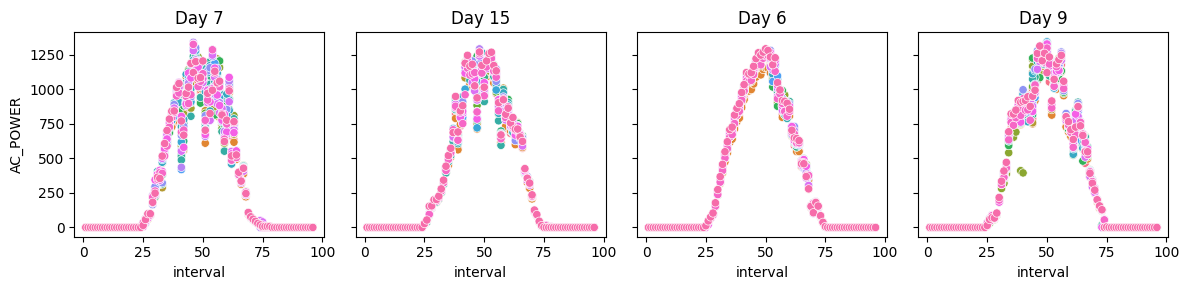

In [48]:
# Check AC power plots after imputing with KNN
plot_most_missing_data_days(df_knn, "AC_POWER")

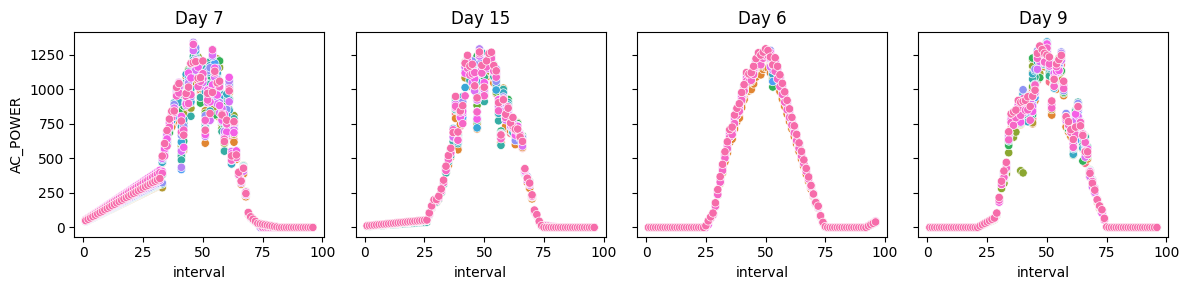

In [49]:
# Check AC power plots after imputing with interpolation
plot_most_missing_data_days(df_inter, "AC_POWER")

#### DAILY YIELD

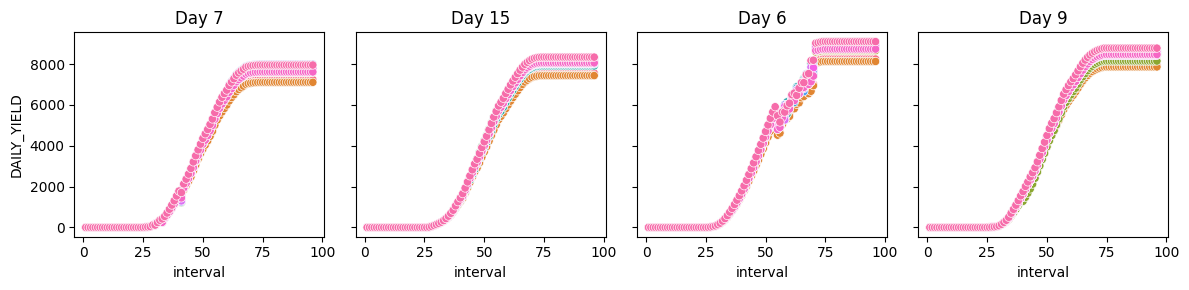

In [50]:
# Check DAILY_YIELD plots after imputing with KNN
plot_most_missing_data_days(df_knn, "DAILY_YIELD")

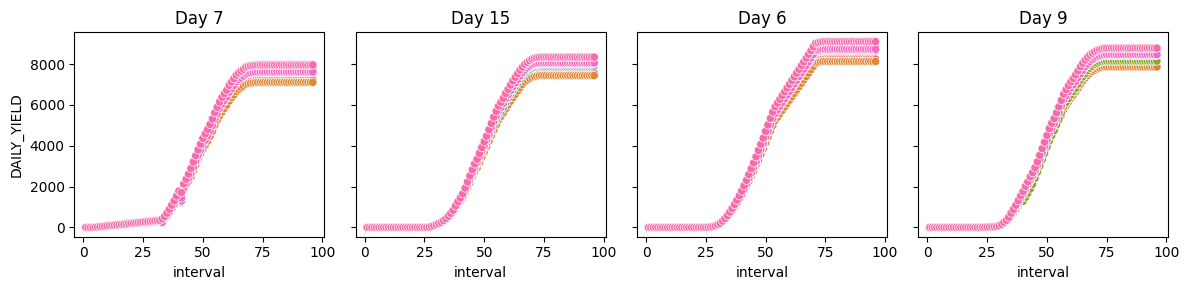

In [51]:
# Check DAILY_YIELD plots after imputing with interpolation
plot_most_missing_data_days(df_inter, "DAILY_YIELD")

#### IRRADIATION

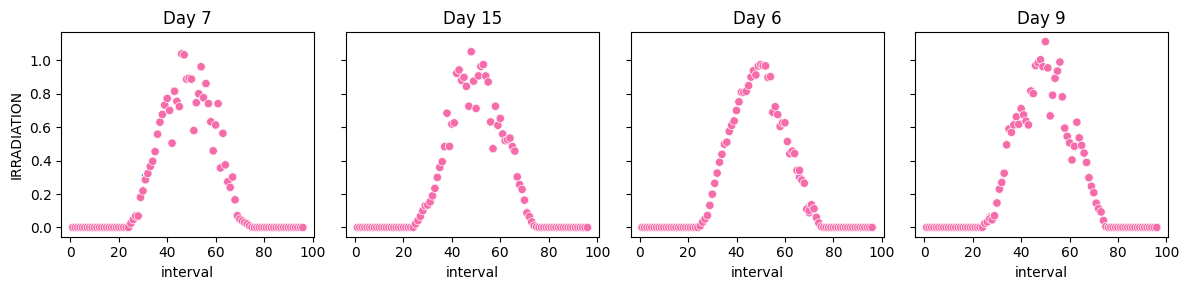

In [52]:
# Check IRRADIATION plots after imputing with KNN
plot_most_missing_data_days(df_knn, "IRRADIATION")

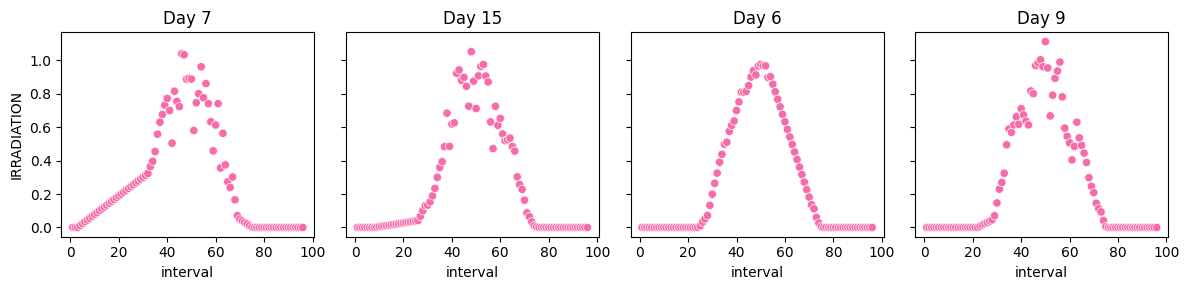

In [53]:
# Check IRRADIATION plots after imputing with interpolation
plot_most_missing_data_days(df_inter, "IRRADIATION")

Upon reviewing the plots of the 4 days with the highest number of missing values, we can make the following observations:

* The KNN imputer exhibits smoother variations compared to interpolation. This difference is particularly noticeable in the AC power and irradiation figures for day 7 and day 6, and the interpolation method fails to produce zero values during nighttime periods in day 7.

* Interpolation yields better results for the Daily yield of day 6, but the KNN imputer still outperforms interpolation on the other days.

* Overall, the results suggest that the KNN imputer performs better across the board. Therefore, we will use it in this study.

In [54]:
# remove all missing values with KNN imputer
data = impute_with_KNN(data)
data.isna().sum()

DATE_TIME              0
DC_POWER               0
AC_POWER               0
DAILY_YIELD            0
TOTAL_YIELD            0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
hour                   0
dayofweek              0
day                    0
interval               0
INVERTER               0
dtype: int64

### Prepare data for training

Although we have addressed outliers and missing values, our data is not yet prepared for model training. Currently, we have multiple inverter datasets combined in a single column, leading to duplicated timestamps. Ideally, we aim to index our data using unique timestamps.

To achieve this, we can aggregate all the inverter data for each 15-minute interval by summing their generated power and daily yield values and calculating the mean of the weather measurements. This approach will result in a minor loss of individual inverter performance information. However, it simplifies the data structure and reduces complexity compared to separating each inverter's data into individual columns.

In [55]:
power_features = ['AC_POWER', 'DC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD']
weather_features = ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']

data_all = pd.concat([data.groupby("DATE_TIME").sum(numeric_only=True)[power_features],
                       data.groupby("DATE_TIME").mean(numeric_only=True)[weather_features]], axis=1)

#add datetime features
data_all['hour'] = data_all.index.hour
data_all['dayofweek'] = data_all.index.dayofweek
data_all['day'] = data_all.index.dayofyear
data_all['day'] = data_all.day.map({data_all.day.unique()[i-1]:i for i in range(1, 35)})
data_all['interval'] = data_all.index.time
data_all['interval'] = data_all.interval.map({times[i-1]: i for i in range(1, len(times)+1)})

The objective of this study is to forecast the solar generated power for the next day, specifically the AC power. Given the high correlation between AC power and DC power (as demonstrated earlier), we have selected AC power as our target variable.

In [56]:
day = 96 # 24*4 (for each 15min intervall)

# shift all data by 1 day so that each features sample
# corresponds to the next day AC_POWER generated
target = data_all.AC_POWER.shift(-day).dropna()
features = data_all[~data_all.AC_POWER.shift(-day).isna()]

In [57]:
data_all.head()

AC_POWER  DC_POWER  DAILY_YIELD  TOTAL_YIELD  \
DATE_TIME                                                           
2020-05-15 00:00:00       0.0       0.0          0.0  150771216.5   
2020-05-15 00:15:00       0.0       0.0          0.0  150771216.5   
2020-05-15 00:30:00       0.0       0.0          0.0  150771216.5   
2020-05-15 00:45:00       0.0       0.0          0.0  150771216.5   
2020-05-15 01:00:00       0.0       0.0          0.0  150761642.0   

                     AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  \
DATE_TIME                                                                   
2020-05-15 00:00:00            25.184316           22.857507          0.0   
2020-05-15 00:15:00            25.084589           22.761668          0.0   
2020-05-15 00:30:00            24.935753           22.592306          0.0   
2020-05-15 00:45:00            24.846130           22.360852          0.0   
2020-05-15 01:00:00            24.621525           22.165423          0.0   

                     hour  dayofweek  day  interval  
DATE_TIME                                            
2020-05-15 00:00:00     0          4    1         1  
2020-05-15 00:15:00     0          4    1         2  
2020-05-15 00:30:00     0          4    1         3  
2020-05-15 00:45:00     0          4    1         4  
2020-05-15 01:00:00     1          4    1         5

In [58]:
# last 4 days will be reserved for testing
split_datetime = -day*4
x_train = features.iloc[:split_datetime]
x_test = features.iloc[split_datetime:]
y_train = target[:split_datetime]
y_test = target[split_datetime:]

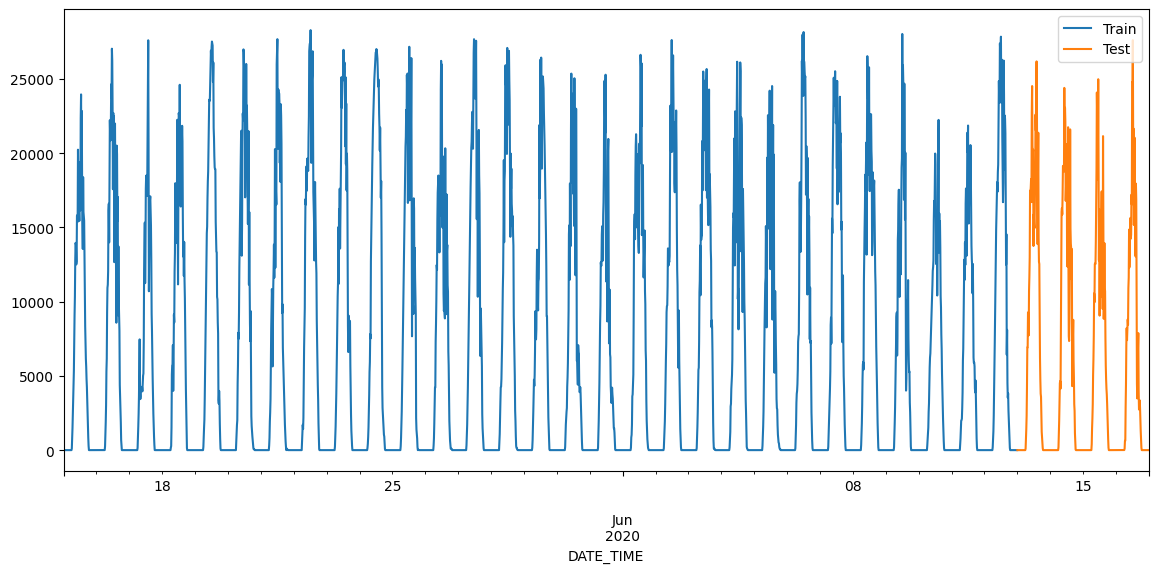

In [59]:
# Plot AC power training and testing date splits
_ = pd.DataFrame(y_train) \
    .rename(columns={'AC_POWER': 'Train'}) \
    .join(pd.DataFrame(y_test).rename(columns={'AC_POWER': 'Test'}), how='outer') \
    .plot(figsize=(14,6))

In [60]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Compute the accuracy errors : MAE, RMSE, R2 score.
def get_prediction_errors(y_true, y_pred):
    R2_score = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"R2 score: {R2_score}")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    return [R2_score, mae, rmse]

In [61]:
def plot_predictions(test, predicted):
    plt.figure(figsize=(14,6))
    plt.plot(test, label='Actual AC power', linewidth=3)
    plt.plot(predicted, label='Predicted AC power', linewidth=3)
    plt.xlabel('Time')
    plt.ylabel('AC Power Generated')
    plt.legend()
    plt.show()

In [62]:
def plot_forecast_day(test, predicted, forecast_pred):
    date_range = pd.date_range(start="2020-06-17 23:45:00", periods=day, freq='15min')
    future_days = pd.DataFrame({'Date': date_range, 'Forecast': forecast_pred})
    future_days.index = future_days["Date"]
    plt.figure(figsize=(14,6))
    plt.plot(test, label='Actual AC power', linewidth=3)
    plt.plot(predicted, label='Predicted AC power', linewidth=3)
    plt.plot(future_days["Forecast"], label='Forecasted AC power', linewidth=3)
    plt.xlabel('Time')
    plt.ylabel('AC Power Generated')
    plt.legend()
    plt.show()

## Building ML Models

### 1- XGBoost :

In [63]:
import xgboost as xgb

xgboost = xgb.XGBRegressor(n_estimators=200,
                           learning_rate=0.01,
                           max_depth=5,
                           min_child_weight=10,
                           base_score=0.5
                          )
xgboost.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], verbose=0)

XGBRegressor(base_score=0.5, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

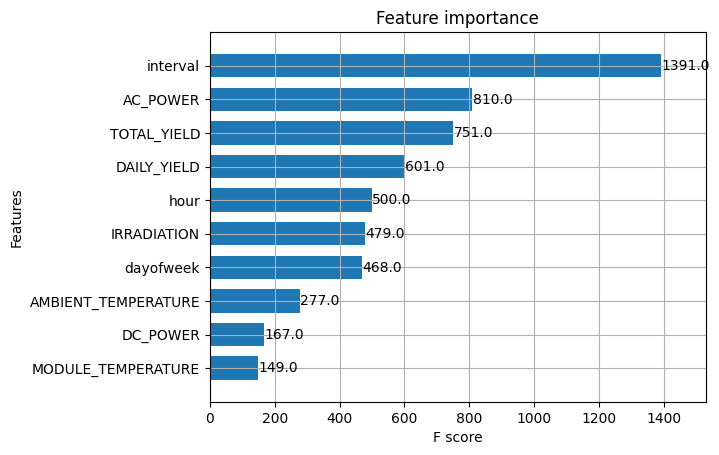

In [64]:
_ = xgb.plot_importance(xgboost, height=0.7)

In [65]:
predicted = xgboost.predict(x_test)
results = pd.concat([y_test, pd.Series(predicted, index=y_test.index)], axis=1)
results.index = data_all.index[-4*day:]
results.columns = ["Actual", "Predicted"]

In [66]:
xgb_errors = get_prediction_errors(results["Actual"], results["Predicted"])

R2 score: 0.8859667975118264
MAE: 1333.8200796990461
RMSE: 2609.8932045114934


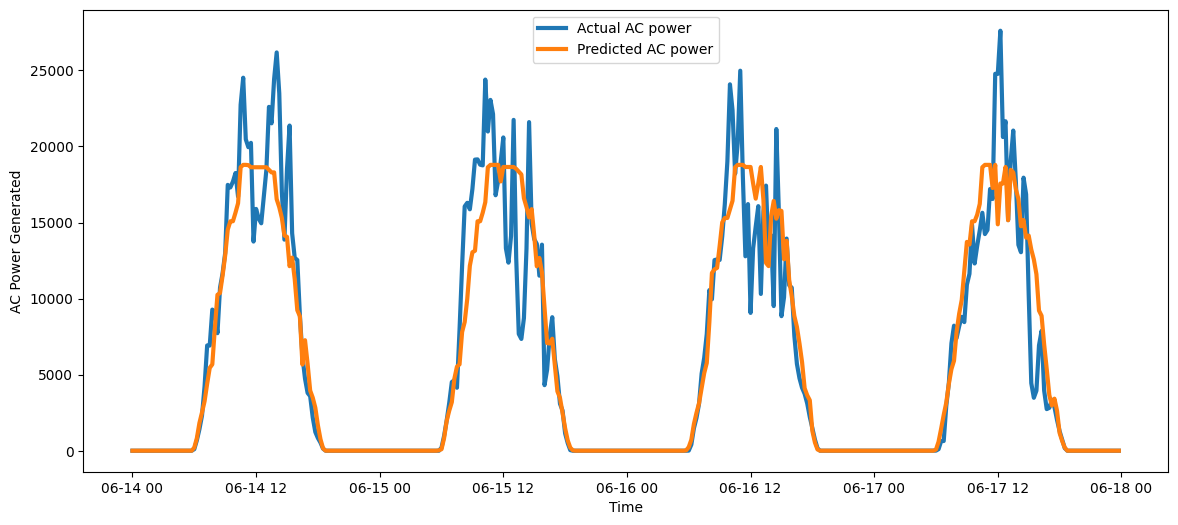

In [67]:
plot_predictions(results["Actual"], results["Predicted"])

### Forecast Next Future Day

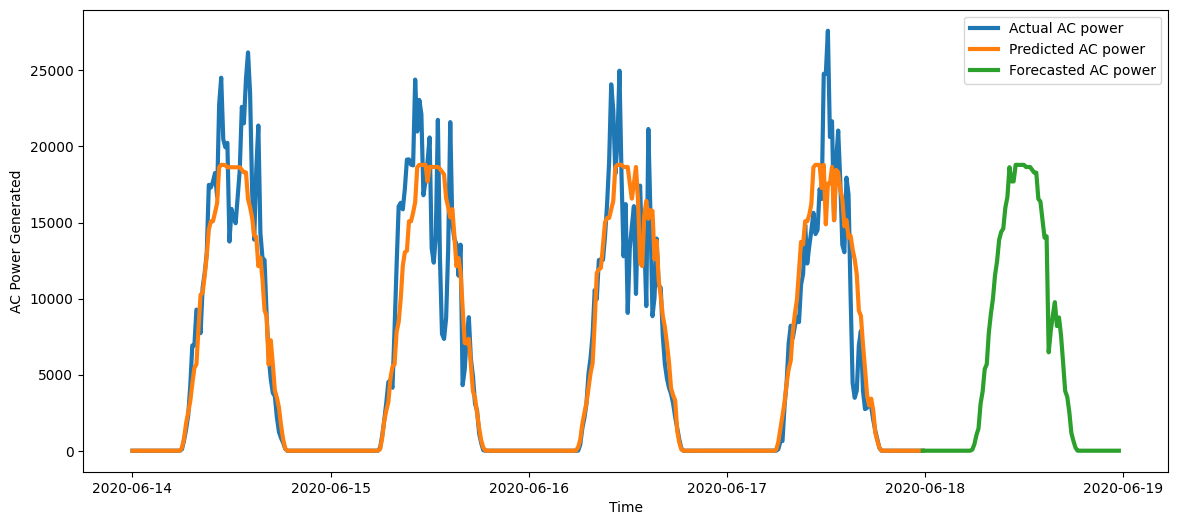

In [68]:
last_day = data_all["2020-06-17 00:00:00":]
last_day_pred = xgboost.predict(last_day)
plot_forecast_day(results["Actual"], results["Predicted"], last_day_pred)

### Observations

After fine tuning the XGBoost hyperparameters by a trial and error method we see that the model demonstrates a relatively high R2 score (89%). However, upon examining the plot and assessing the MAE/RMSE error, it becomes evident that the model's predictions lack accuracy, particularly during the midday period. The model struggles to adapt to rapid fluctuations, resulting in underestimated values for the generated AC power. This pattern is observed not only in the current predictions but also extends to the next-day forecast.

We also found from the features importance plot that the model rely heavily on the day 15-min interval in its predictions (less on the AC power generated in the previous days) which is reasonable, considering that the AC power generated is influenced by the varying irradiation from the sun throughout each hour of the day.

### 2- Random Forest :

In [69]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=200, max_depth=7)
rf.fit(x_train, y_train)

RandomForestRegressor(max_depth=7, n_estimators=200)

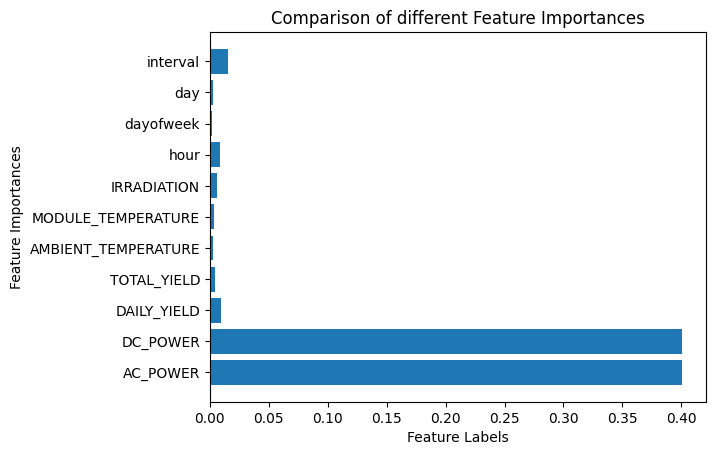

In [70]:
feature_importance = rf.feature_importances_

# Normalizing the individual importances
feature_importance_normalized = np.std([tree.feature_importances_ for tree in
                                        rf.estimators_],
                                        axis=0)

plt.barh(x_train.columns, feature_importance_normalized)
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances')
plt.show()

In [71]:
results["Predicted"] = rf.predict(x_test)
rf_errors = get_prediction_errors(results["Actual"], results["Predicted"])

R2 score: 0.8609205913163733
MAE: 1524.2833043897035
RMSE: 2882.2954343124


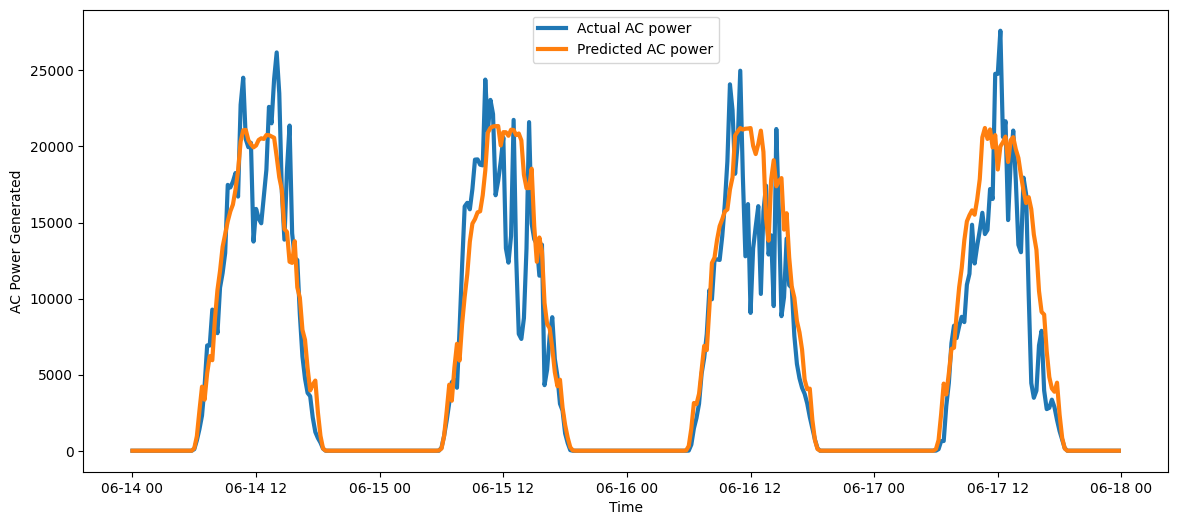

In [72]:
plot_predictions(results["Actual"], results["Predicted"])

### Forecast Next Future Day

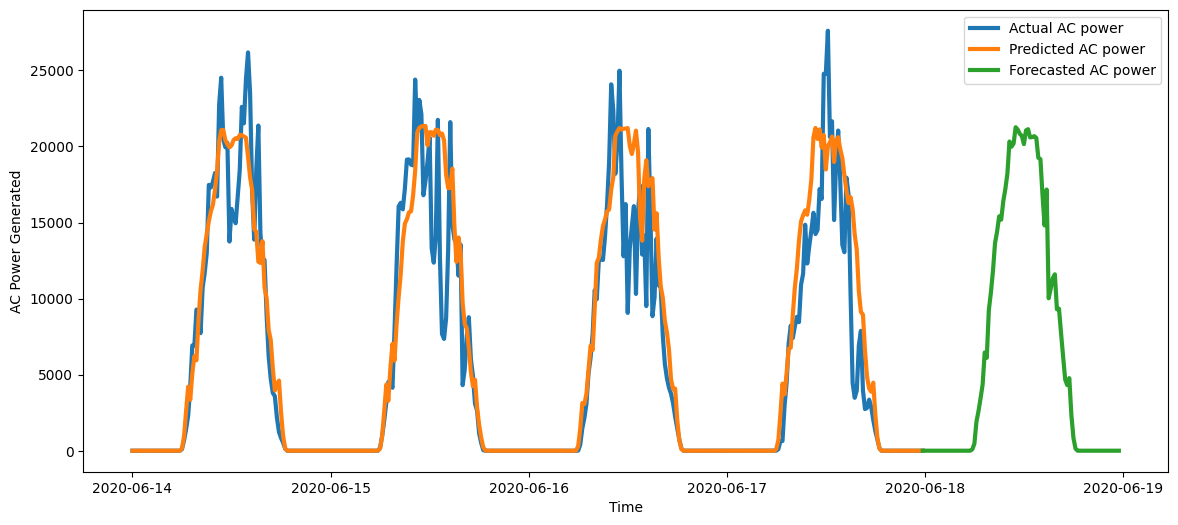

In [73]:
last_day_pred = rf.predict(last_day)
plot_forecast_day(results["Actual"], results["Predicted"], last_day_pred)

### Observations

The Random Forest model also gives a good R2 score (86%), albeit lower than that produced by the XGBoost model. Examining the plot reveals that, like the XGBoost model, the Random Forest model faces challenges in adapting to rapid fluctuations during the midday period. However, it does not exhibit as much underestimation of the generated power as the XGBoost model. We also notice that the Random Forest model provides a similar forecast for the future day compared to the XGBoost model.

Additionally, the features importance plot indicate that the model does not heavily consider the 15-minute interval of the day. Instead, it focuses on the AC/DC power generated in the previous days.

## LSTM Model

Both ML algorithms provided relatively accurate prediction results, but they encountered challenges in adapting to the fluctuations in generated power. Consequently, we have opted to explore a DL approach, specifically leveraging the capabilities of RNN and LSTM neural networks known for their effectiveness in forecasting based on past data. The chosen model is LSTM, and it's essential to acknowledge that training it poses a challenge due to the limited size of the dataset used in this study. The model might encounter difficulty capturing all the patterns connecting the AC power generated and the associated features.

For the LSTM network, the input will consist of power and weather measurements from the past three days. The network will be tasked with predicting the AC power generated at each 15-minute interval for the following day.

### 1- Data scaling

In [74]:
from sklearn.preprocessing import MinMaxScaler

def scale_data(data):
    features = data_all.iloc[:, 1:]
    target = data_all.iloc[:, 0]
    x_scaler = MinMaxScaler()
    X = pd.DataFrame(x_scaler.fit_transform(features))

    y_scaler = MinMaxScaler()
    Y = pd.DataFrame(y_scaler.fit_transform(target.values.reshape(-1, 1)))

    scaled_data = pd.concat([Y, X], axis=1)
    scaled_data.columns = data.columns

    return scaled_data, y_scaler

In [75]:
scaled_data, y_scaler = scale_data(data_all)

### 2- Construct Window Data

In [76]:
from sklearn.model_selection import TimeSeriesSplit

def create_lstm_data(data, past_days, future_days):
    spliter = TimeSeriesSplit(n_splits=30, max_train_size=past_days*day, test_size=future_days*day)
    indices = []
    for train_indices, test_indices in spliter.split(data.iloc[:-day*past_days]):
        indices.append((train_indices, test_indices))

    X_train = []
    y_train = []
    for i in range(past_days-1, len(indices)-past_days):
        X_train.append(data.iloc[indices[i][0]])
        y_train.append(data.AC_POWER[indices[i][1]])

    X_test = []
    y_test = []
    for i in range(len(indices)-past_days, len(indices)):
        X_test.append(data.iloc[indices[i][0]])
        y_test.append(data.AC_POWER[indices[i][1]])
    
    x_train_arr = np.array(X_train)
    y_train_arr = np.array(y_train)
    x_test_arr = np.array(X_test)
    y_test_arr = np.array(y_test)

    return [x_train_arr, y_train_arr, x_test_arr, y_test_arr]

In [77]:
X_train, Y_train, X_test, Y_test = create_lstm_data(scaled_data, 3, 1)

### 3- Build & train LSTM

In [78]:
import tensorflow as tf
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

lstm_model = Sequential()
lstm_model.add(LSTM(256, return_sequences=True, kernel_initializer=tf.initializers.zeros() , input_shape=X_train.shape[1:]))
lstm_model.add(Dropout(0.3))
lstm_model.add(LSTM(256, kernel_initializer=tf.initializers.zeros()))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(day))
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 288, 256)          274432    
                                                                 
 dropout (Dropout)           (None, 288, 256)          0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 96)                24672     
                                                                 
Total params: 824416 (3.14 MB)
Trainable params: 824416 (3.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [79]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=20,
                                                    mode='min',
                                                    restore_best_weights=True)

lstm_model.compile(optimizer="adam", loss="MSE")
lstm_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=200, callbacks=[early_stopping], verbose=0)

<Axes: >

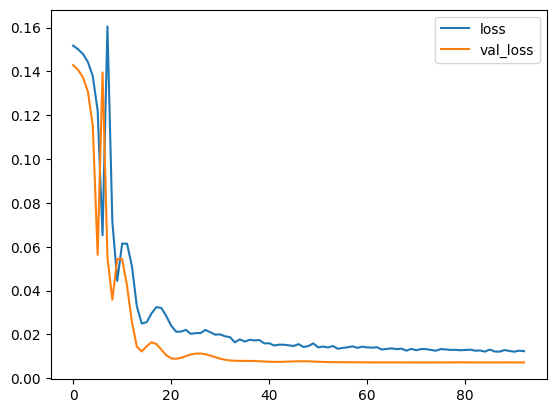

In [80]:
history = pd.DataFrame(lstm_model.history.history)
history.plot()

In [81]:
# construct 3 days window data to predict the AC power of last 3 days
input_test_day_1 = np.array(scaled_data.iloc[-6*day:-3*day, :])
input_test_day_2 = np.array(scaled_data.iloc[-5*day:-2*day, :])
input_test_day_3 = np.array(scaled_data.iloc[-3*day:, :])
input_test_days = np.array([input_test_day_1, input_test_day_2, input_test_day_3])

In [82]:
lstm_predictions = lstm_model.predict(input_test_days)
y_test = data_all.iloc[-3*day:, 0]
y_pred = y_scaler.inverse_transform(lstm_predictions.reshape(3*day, 1)).reshape(-1)
lstm_errors = get_prediction_errors(y_test, y_pred)

1/1 [==============================] - 1s 706ms/step
R2 score: 0.8342418752041802
MAE: 1636.0042959397058
RMSE: 3047.5905544292773


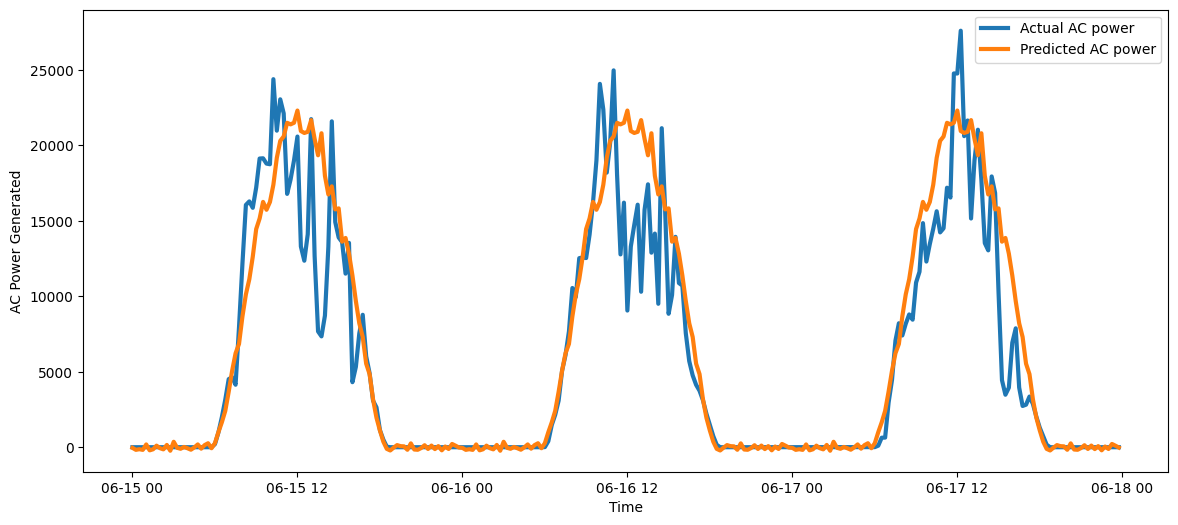

In [83]:
results = pd.concat([y_test, pd.Series(y_pred, index=y_test.index)], axis=1)
results.index = data_all.index[-3*day:]
results.columns = ["Actual", "Predicted"]
plot_predictions(results["Actual"], results["Predicted"])

### Forecast Next Future Day

1/1 [==============================] - 0s 27ms/step


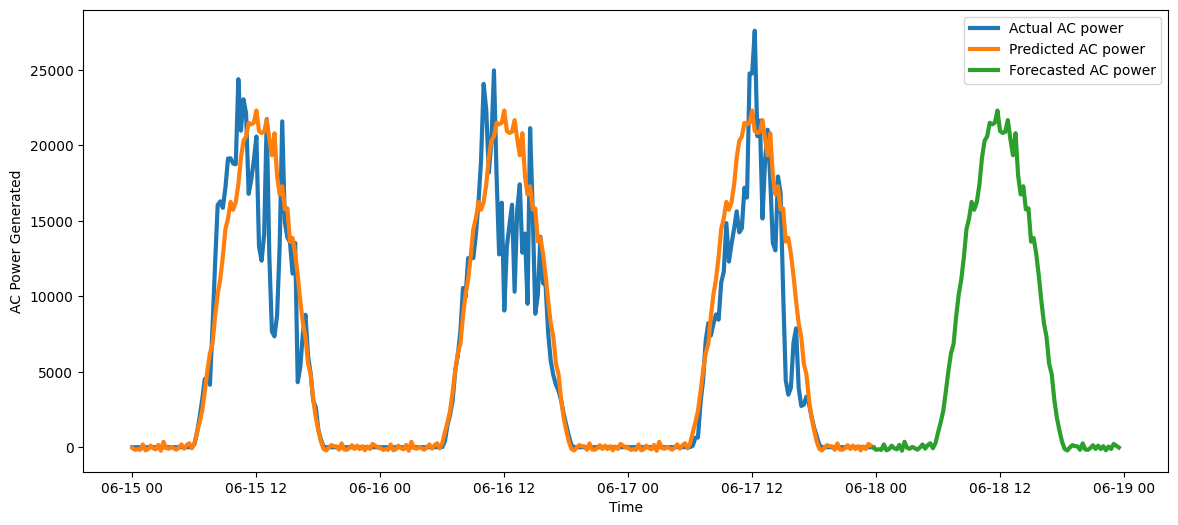

In [84]:
last_day = np.array(scaled_data)[-3*day:, :]
last_day_arr = np.array([last_day])
future_day_pred = lstm_model.predict(last_day_arr)
future_pred = y_scaler.inverse_transform(future_day_pred.reshape(day, 1)).reshape(-1)
plot_forecast_day(results["Actual"], results["Predicted"], future_pred)

### Observations

As anticipated, the LSTM model faced limitations in learning from the restricted input data, resulting in a lower R2 score compared to the ML models (only 83%). The model consistently produced similar predictions for nearly every day. Additionally, it struggled to adapt to the rapid fluctuations in generated power. It's noteworthy that the model introduced minor fluctuations during nighttime, even though power generation should ideally be zero during those periods. These nighttime fluctuations, while present, can be disregarded as they are not critical for the prediction needs during those times.

## Final Results

In [85]:
stats = pd.DataFrame([xgb_errors, rf_errors, lstm_errors],
                     columns=["R2 score", "MAE", "RMSE"],
                     index=["XGBoost", "RandomForest", "LSTM"]
                     )
stats.head()

R2 score          MAE         RMSE
XGBoost       0.885967  1333.820080  2609.893205
RandomForest  0.860921  1524.283304  2882.295434
LSTM          0.834242  1636.004296  3047.590554

## Conclusion

What insights can be drawn from our study?

- The trained models demonstrated commendable performance across all metrics considered (R2 score, MAE, RMSE), with the XGBoost model achieving the highest R2 score of approximately 89%.

- Despite its superior R2 score, the XGBoost model exhibited a drawback in underestimating the AC power generated, unlike the Random Forest and LSTM models, which provided closer predictions.

- All trained models faced challenges in adapting to the rapid fluctuations in generated power, ultimately resulting in forecasts that averaged out generated power values.

- The study highlights that the dataset's size, comprising only 34 days, is insufficient for the models to truly comprehend the relationship between variations in AC power generation and other power and weather measured from the preceding days. This limitation makes forecasting tasks notably challenging, as they typically require multiple years of data for a more comprehensive understanding.